In this project I analyse the garment workers productivity dataset by doing some descriptive and exploratory analysis. The ultimate purpose of this project is to understand how productivity evolves across time, change within and between groups and building a model that predicts a worker's productivity given their characteristics. I will provide brief comments as to what each code chunk does.

I begin by loading the main packages. For ease of following along and tractability, I load package on the fly.

In [1]:
import numpy as np #Vectorized operations
import pandas as pd #Data wrangling
import matplotlib.pyplot as plt #For visualization
import seaborn as sns #Enhanced visualization features

import warnings #Hiding warnings
warnings.filterwarnings('ignore')

Load the data correct some data entry errors. Code in comments executes if you have a copy of the data.

In [2]:
"""
try:
    url = 'https://archive.ics.uci.edu/static/public/597/productivity+prediction+of+garment+employees.zip'
    garment = pd.read_csv(url)
except Exception as e:
    print(f'Data could not be accessed from URL: {e}')
    print('Trying to access data locally')
    try:
        garment = pd.read_csv('/home/mutwiri/DataScience/Python/garment_productivity/data/garment.csv')
    except Exception as e:
        raise Exception ('Data could not be accessed downloaded or accessed locally') from e
"""

url = 'https://archive.ics.uci.edu/static/public/597/productivity+prediction+of+garment+employees.zip'
garment = pd.read_csv(url)

garment['date'] = pd.to_datetime(garment['date'])
#garment = garment.drop(columns='date')

garment['quarter'] = garment['quarter'].str.lower()

garment ['wip'] = garment['wip'].replace('NaN', 0)

garment['department'] = garment['department'].replace('sweing','sewing')
garment['department'] = garment['department'].replace('finishing ','finishing')

It's good practice to examine a random sample from the data.

In [3]:
garment.sample(5)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
1176,2015-03-11,quarter2,finishing,Wednesday,4,0.75,3.94,NaN,1920,0,0.0,0,0,8.0,0.813309
687,2015-02-09,quarter2,finishing,Monday,9,0.80,3.94,NaN,960,0,0.0,0,0,8.0,0.697708
612,2015-02-04,quarter1,sewing,Wednesday,11,0.70,10.05,1042.0,6120,60,0.0,0,0,53.0,0.700279
392,2015-01-22,quarter4,finishing,Thursday,12,0.60,4.08,NaN,5400,0,0.0,0,0,9.0,0.327407
117,2015-01-07,quarter1,sewing,Wednesday,3,0.80,19.87,924.0,9900,50,0.0,0,0,55.0,0.800274


Then extract some descriptive statistics from the data. 
We observe that there is a high rate of NAs in the `wip` feature.

In [4]:
garment.drop('date',axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
team,1197.0,6.426901,3.463963,1.000000,3.000000,6.000000,9.000000,12.000000
targeted_productivity,1197.0,0.729632,0.097891,0.070000,0.700000,0.750000,0.800000,0.800000
smv,1197.0,15.062172,10.943219,2.900000,3.940000,15.260000,24.260000,54.560000
wip,691.0,1190.465991,1837.455001,7.000000,774.500000,1039.000000,1252.500000,23122.000000
over_time,1197.0,4567.460317,3348.823563,0.000000,1440.000000,3960.000000,6960.000000,25920.000000
incentive,1197.0,38.210526,160.182643,0.000000,0.000000,0.000000,50.000000,3600.000000
idle_time,1197.0,0.730159,12.709757,0.000000,0.000000,0.000000,0.000000,300.000000
idle_men,1197.0,0.369256,3.268987,0.000000,0.000000,0.000000,0.000000,45.000000
no_of_style_change,1197.0,0.150376,0.427848,0.000000,0.000000,0.000000,0.000000,2.000000
no_of_workers,1197.0,34.609858,22.197687,2.000000,9.000000,34.000000,57.000000,89.000000


We can also use the `Description` class to generate some custom statistics.

In [5]:
from statsmodels.stats.descriptivestats import Description

smv_desc = Description(garment[['smv','no_of_workers','targeted_productivity','actual_productivity']],
                       stats = ['mean','std_err','range','max','min','median','skew'])

desc_table = str(smv_desc.summary())

column_names = ' '.join(garment[['smv', 'no_of_workers', 'targeted_productivity', 'actual_productivity']].columns)
desc_table = desc_table.replace('Descriptive Statistics', f'Descriptive Statistics\n{column_names}')

print(desc_table)

         Descriptive Statistics
smv no_of_workers targeted_productivity actual_productivity         
mean     15.06   34.61   0.7296   0.7351
std_err 0.3163  0.6416 0.002829 0.005043
range    51.66      87     0.73   0.8867
max      54.56      89      0.8     1.12
min        2.9       2     0.07   0.2337
skew    0.4054 -0.1116   -2.141  -0.8065
median   15.26      34     0.75   0.7733
----------------------------------------


Prepare the data to plot the 5 days moving average chart.

In [6]:
five_day_ma = garment[['date','department','no_of_workers']].pivot_table(
    index='date',columns='department',values='no_of_workers',
    aggfunc='mean').rolling(window=5,closed='both').mean()
five_day_ma = pd.DataFrame(five_day_ma.stack()).reset_index().rename({0: 'no_of_workers'},axis=1).set_index('date')

five_day_ma.tail()

,department,no_of_workers
date,,
2015-03-09,sewing,51.451515
2015-03-10,finishing,9.941414
2015-03-10,sewing,51.576515
2015-03-11,finishing,9.830303
2015-03-11,sewing,51.632071


We can also check for patterns/associations within the departments ...

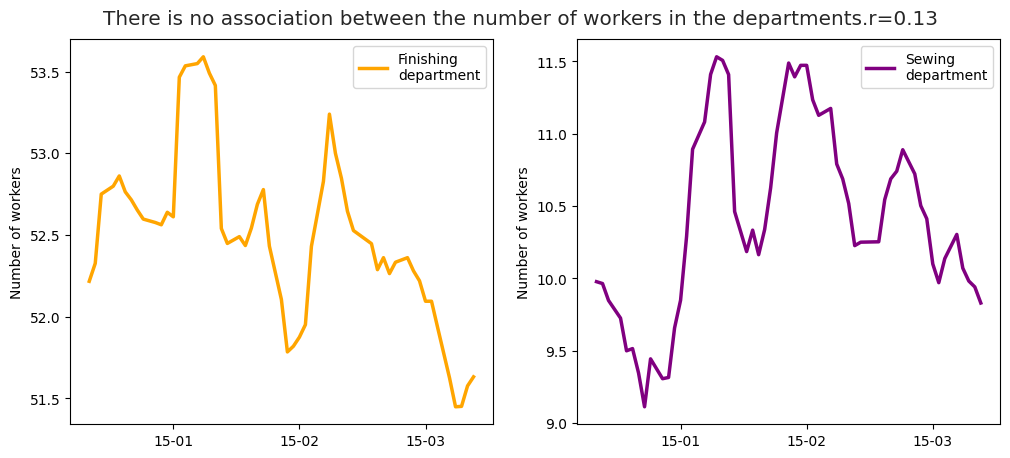

In [7]:
from pandas.plotting import register_matplotlib_converters

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from statistics import correlation

register_matplotlib_converters()

date_format = DateFormatter(fmt='%y-%m')

stacked_five_day_ma = five_day_ma.pivot_table(index='date',columns='department',values='no_of_workers')

corr = correlation(stacked_five_day_ma['finishing'],stacked_five_day_ma['sewing']).__round__(2)

fig = plt.figure(figsize=(12,5))

ax1, ax2  = fig.subplots(nrows=1, ncols=2)

sns.lineplot(five_day_ma[five_day_ma['department'] == 'sewing'],
              x = 'date', y = 'no_of_workers',
              color = 'orange', ax = ax1, label ='Finishing\ndepartment', linewidth = 2.5)

sns.lineplot(five_day_ma[five_day_ma['department'] == 'finishing'], 
             x = 'date', y = 'no_of_workers',
             color = 'purple', ax  = ax2, label = 'Sewing\ndepartment', linewidth = 2.5)
ax1.xaxis.set_major_formatter(date_format)
ax2.xaxis.set_major_formatter(date_format)
ax1.set_xlabel(xlabel='')
ax2.set_xlabel(xlabel='')
ax1.set_ylabel(ylabel='Number of workers')
ax2.set_ylabel(ylabel='Number of workers')
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
sns.set(style = 'whitegrid')

plt.suptitle(f"There is no association between the number of workers in the departments.r={corr}",y = .94)

plt.savefig('corr_chart', dpi = 320, format = 'png')


... and check-out the distribution of samples across the two departments.

[Text(0, 0, 'Finishing'), Text(1, 0, 'Sewing')]

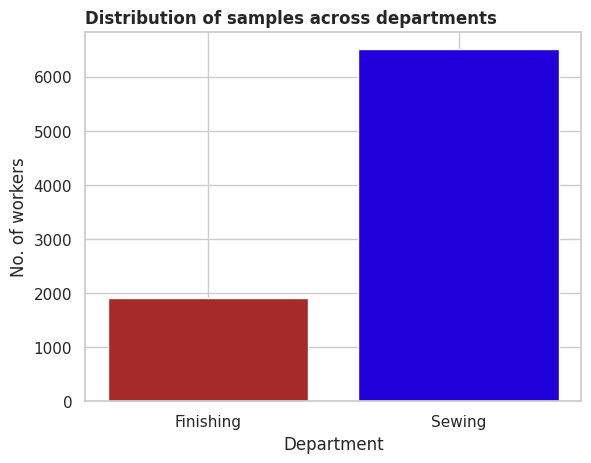

In [8]:
over_time_dept = garment[['department','over_time']].groupby('department').agg(func='mean')

fig, ax = plt.subplots()

plt.bar(over_time_dept.index,over_time_dept['over_time'], color = ['brown','#2200db'])
plt.title('Distribution of samples across departments',fontweight='bold',loc='left')
plt.xlabel('Department')
plt.ylabel('No. of workers')
ax.set_xticklabels(over_time_dept.index.str.title())


[Text(0, 0, 'Finishing'), Text(1, 0, 'Sewing')]

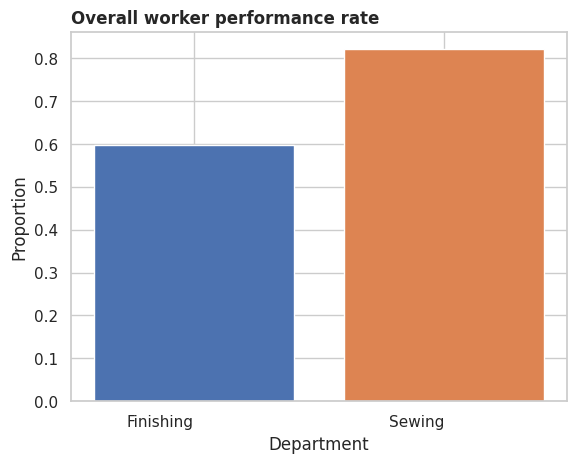

In [9]:
from matplotlib.ticker import FuncFormatter

color_palette = sns.color_palette(palette = 'deep',n_colors=2)

def to_title(text: str, _ ):
    return text.title()


target_achievement = garment.assign(
    above = garment['actual_productivity'] > garment['targeted_productivity']
)[['department','above']].groupby('department').mean()
target_achievement

fig,ax = plt.subplots()
plt.bar(target_achievement.index,target_achievement['above'],color = color_palette)
plt.title('Overall worker performance rate',fontweight='bold',loc='left')
plt.xlabel('Department')
plt.ylabel('Proportion')
ax.set_xticklabels(target_achievement.index.str.title(), ha = 'right')

Subset necessary columns for visualization

In [10]:
productivity= garment[['date','department','actual_productivity','targeted_productivity']]

productivity = productivity.melt(
    id_vars= ['date','department'],
    value_vars = ['actual_productivity','targeted_productivity'],
    var_name= 'metric',
    value_name= 'productivity'
)
productivity['productivity'] = productivity['productivity'].round(1)
productivity.sample(5)

,date,department,metric,productivity
992,2015-03-01,sewing,actual_productivity,0.7
257,2015-01-14,sewing,actual_productivity,0.3
293,2015-01-17,sewing,actual_productivity,0.7
1975,2015-02-15,finishing,targeted_productivity,0.7
1849,2015-02-07,sewing,targeted_productivity,0.7


Plot a line chart that tracks the actual and targeted productivity.
We can also see how the differences evolve over time.

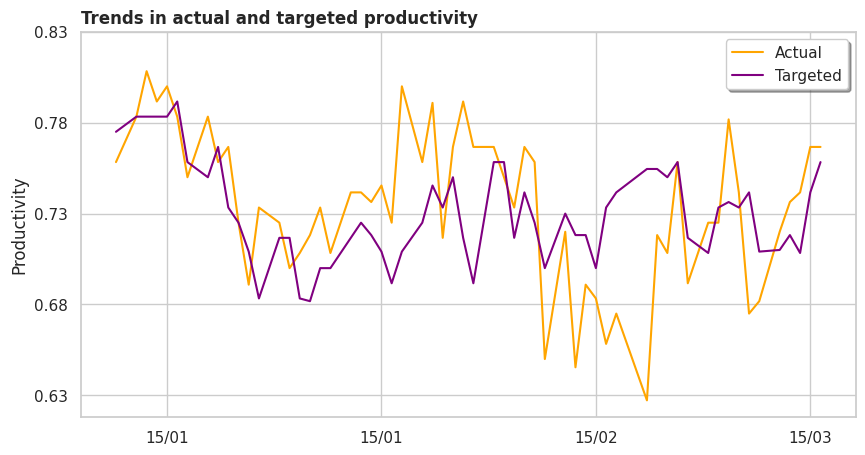

In [11]:
from pandas.plotting import register_matplotlib_converters

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

date_format = DateFormatter(fmt= '%y/%m')


fig = plt.figure(figsize = (10,5)) 
ax = fig.subplots(1,1)

sns.lineplot(productivity.query('department == "sewing"'),
             x ='date', y = 'productivity', hue = 'metric', 
             palette= ['orange','purple'], err_style= None, ax = ax)
ax.xaxis.set_major_formatter(formatter = date_format)
ax.xaxis.set_major_locator(locator= mdates.WeekdayLocator(interval=3))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.set_title('Trends in actual and targeted productivity',fontweight = 'bold', loc= 'left')
ax.set_ylabel(ylabel='Productivity')
ax.set_xlabel(xlabel='')
ax.set_yticks(ticks= np.linspace(.63,.83,5))
ax.legend(loc ='upper right', labels = ['Actual','Targeted'], shadow = True)

Remove outliers and classify the procuctivity by a threshold.
There is not much imbalance in the target variable

In [12]:
from sklearn.neighbors import LocalOutlierFactor

loc = LocalOutlierFactor(n_neighbors=20)

outlier_scores = loc.fit_predict(garment.drop(columns=['wip','date','quarter','team','department','day',]))

garment['outlier_score'] = outlier_scores
garment = garment[garment['outlier_score']!= -1].drop(columns='outlier_score')


garment['productive'] = pd.Categorical(np.where(garment['actual_productivity'] > .7, 1, 0))

garment['team'] = pd.Categorical(np.array(garment['team']))
garment = garment.drop(columns=['date','targeted_productivity','actual_productivity'])

garment.productive.value_counts()

productive
1    634
0    256
Name: count, dtype: int64

Now that the data is ready for modelling, the next step is splitting the data into a training and testing set for modelling. Setting random seed is important of reproducibility/replication of results obtained here.

In [13]:
from sklearn.model_selection import train_test_split

y = garment['productive']
X = garment.drop('productive',axis=1)

np.random.seed(7634)

X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=.2, stratify= y)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

X_train['index']= X_train.reset_index().index
X_train = X_train.set_index('index')

X_test['index']= X_test.reset_index().index
X_test = X_test.set_index('index')

The data contains categorical and numneric columns. Implementing some algorithms in machine learning like support vector machines and some statistical transformation like centering and scaling require categorical columns to be encoded by numerical values or the numerical columns to be transformed by some factor. First, I extract the categorical and numerical columns into a dictionary which will be used to map column names to data after transformations.

In [14]:
numeric_cols = X_train.select_dtypes(include='number').columns.to_list()
categorical_cols = a=X_train.select_dtypes(include=['object','category']).columns.to_list()

cols_dict = {col_num: col_name for col_num,col_name in zip(range(29),pd.get_dummies(X_train,drop_first=True).columns.to_list())}

Column-specific transformations are made using the `ColumnTransformer` class. 

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer


from sklearn.compose import ColumnTransformer,make_column_selector

from sklearn.pipeline import make_pipeline

one_hot = OneHotEncoder(drop='first')

scale_impute = make_pipeline(
    StandardScaler(),KNNImputer(n_neighbors=20)
)

pre_processor = ColumnTransformer(
    transformers= [
        ('scale_impute',scale_impute,make_column_selector(dtype_include='number')),
        ('one_hot',one_hot,make_column_selector(dtype_include=['object','category']))
    ]
)
pre_processor

ColumnTransformer(transformers=[('scale_impute',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('knnimputer',
                                                  KNNImputer(n_neighbors=20))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc17aaf8ee0>),
                                ('one_hot', OneHotEncoder(drop='first'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc1797bc3a0>)])

Column names change after transformations. The dictionary `cols_dict` can be used to map them back in the data

In [16]:
X_train = pd.DataFrame(pre_processor.fit_transform(X_train,y_train)).rename(mapper=cols_dict,axis=1)
X_test = pd.DataFrame(pre_processor.fit_transform(X_test,y_test)).rename(mapper=cols_dict,axis=1)

Here I start the modelling process by using the simple but powerful logistic regression model. This model is frequently used in aplications of deep learning especially as an activation function for signals. The model optimizes weights for each feature in order classify samples into their classes as accurately as possible given a threshold.

In [17]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

logistic_model = LogisticRegressionCV(
    solver='liblinear',
    penalty='l2',
    cv=10,
    n_jobs=-1
    )

logistic_model.fit(X_train,y_train)

logistic_model

LogisticRegressionCV(cv=10, n_jobs=-1, solver='liblinear')

After training the model, we can use it to predict on data not seen during the training process and then calculate the accuracy of the model.

In [18]:
logistic_model_preds = logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test,logistic_model_preds)
print(f'{logistic_accuracy:.2f}')

0.81


We can try a other more complicated models which have parameters that we can adjust to optimize the model further. These parameters that we can adjust by setting a grid of values to search from are called hyperameters. The support vector classifier is one of these models. This algorithms minimizes the loss function by estimating an a line or hyperplane that maximizes the distance between training samples with different labels. This line is defining a few of the training samples that are closest. These trainig samples are known as the support vectors.This enables the model to quickly and easily learn from the data. Since the separation between trainig samples is not always linear, this algorithms supports non-linear using kernel transformations like the polynomial function and the radial basis functions.

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
svc = SVC(kernel='poly',degree=2)

svc_grid = {
    'C': [1.5,2.5,3],
    'gamma': [.05,.1,.5],
    #'kernel': ['linear','poly','rbf'],
    #'degree': [2,3]
}

svc_tune_grid = GridSearchCV(estimator=svc,scoring='f1',
                             param_grid=svc_grid,
                             refit=True,
                             n_jobs=-1,cv=10
                             )

svc_tune_grid.fit(X_train,y_train)
svc_tune_grid.best_params_

{'C': 1.5, 'gamma': 0.1}

The process of searching for the best parameter combination is iterative and we do so by examining a validation curve. A validation curve shows the performance of a model on the training and testing set for different values of a parameter. We narrow down to the range that maximizes model accuracy.

In [20]:
from sklearn.model_selection import validation_curve

param_range_C = np.round(np.linspace(0,5,8),2)
param_range_gamma = np.round(np.linspace(0.01,.5,10),2)

train_scores_C, test_scores_C = validation_curve(
        estimator= svc_tune_grid.best_estimator_,
        X= X_train,
        y= y_train,
        param_name='C',
        param_range=param_range_C,
        cv=10
    )

train_scores_gamma, test_scores_gamma = validation_curve(
        estimator= svc_tune_grid.best_estimator_,
        X= X_train,
        y= y_train,
        param_name='gamma',
        param_range=param_range_gamma,
        cv=10
    )

After obtaining the performance scores, we can now visualize them

Text(0.5, 0.98, 'Cross Validation Curves for C and gamma')

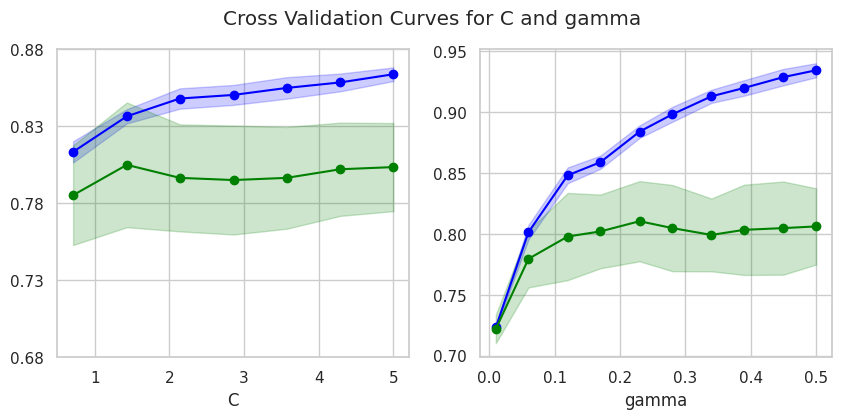

In [21]:
from matplotlib.axes._axes import Axes

def plot_validation(train_scores, test_scores,param_range: list[float], ax: Axes| None = None):

    train_mean = np.mean(train_scores,axis=1)
    train_std = np.std(train_scores,axis=1)

    test_mean = np.mean(test_scores,axis=1)
    test_std = np.std(test_scores,axis=1)

    ax.plot(param_range,train_mean,color = 'blue',marker='o',label = 'Training performance')
    ax.fill_between(param_range,
                    y1 = train_mean+train_std,
                    y2 = train_mean-train_std,
                    color = 'blue',
                    alpha = .2)
    ax.plot(param_range,test_mean,color = 'green',marker = 'o',label = 'Testing performance')
    ax.fill_between(param_range,
            y1 = test_mean+test_std,
            y2 = test_mean-test_std,
            color = 'green',
            alpha = .2)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
import matplotlib.ticker as ticker

plot_validation(train_scores_C,test_scores_C,param_range=param_range_C,ax= ax1)
plot_validation(train_scores_gamma,test_scores_gamma,param_range=param_range_gamma,ax = ax2)
ax1.set_xlabel('C')
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter(fmt='{x:.2f}'))
ax1.set_yticks(np.linspace(.68,.88,5))
ax2.set_xlabel('gamma')
plt.suptitle('Cross Validation Curves for C and gamma')

The best model for the support vector classifier is the one with cost-complexity of 3, gamma of 0.1 and a polynomial kernel function of degree 2. This is also seen in the charts above.

In [22]:
svc_model = svc_tune_grid.best_estimator_
svc_model

SVC(C=1.5, degree=2, gamma=0.1, kernel='poly')

We see much improvement in accuracy for the support vector classifier

In [23]:
svc_model_preds = svc_model.predict(X_test)
svc_model_accuracy = accuracy_score(y_pred=svc_model_preds,y_true=y_test)
svc_model_accuracy
print(f'{svc_model_accuracy:.2f}')

0.80


We could also try out tree-based models. Tree-based methods build on decision trees. Decision trees iterate over the data calculating splits within variables the maximizes the accuracy of the model. This results in many points(nodes) at which we split a variable. To maximizes the overall acciracy of the tree, the purity of the nodes is maximized. First let us tune a Random Forest model. This model averages the results many decision trees built on a  subsample of the dataset which decision. The number of variables that are considered for splitting are a ramdom subset of the existing columns. These layers of randomness reduce variance but at a cost of slightly higher bias.

In [24]:
from sklearn.ensemble import RandomForestClassifier

rdf_clf = RandomForestClassifier(criterion='log_loss')

rdf_grid = {
    'max_depth': [5,10,15,20],
    'min_samples_split': [5,7,10]
}

rdf_tune_grid = GridSearchCV(rdf_clf,param_grid=rdf_grid,cv=10,scoring='f1',n_jobs=-1,refit=True)
rdf_tune_grid.fit(X_train,y_train)
rdf_model = rdf_tune_grid.best_estimator_
rdf_model

RandomForestClassifier(criterion='log_loss', max_depth=10, min_samples_split=5)

The higher bias is a good tradeoff for higher accuracy. The random forest model is slightly better.

In [25]:
rdf_preds = rdf_model.predict(X_test)
rdf_model_accuracy = accuracy_score(y_true=y_test,y_pred=rdf_preds)
print(f'{rdf_model_accuracy:.2f}')

0.83


We can also try out a gradient boosted classifier. A boosted classifier is built from a simple estimator like linear regression model or a simple decison tree which is then fit to the errors made by the previous model. How fast the model learns depends on the learning rate parameter. Smaller values might lead to overfitting and computational resources/time while large values might result in more bias. To balance this trade-off, a range of values for the learning rate parameter is used to fit many values and the value that results in highest accuiracy is selected.

In [26]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(booster = 'gbtree', n_estimators= 1000)

xgb_grid= {
    'eta': [.15,.1,.05],
    'max_depth': [3,5,7],
    'min_child_weight': [3,5]
}

xgb_tune_grid = GridSearchCV(
    estimator=xgb_clf,param_grid=xgb_grid,
    scoring='f1',cv=10,n_jobs=-1,refit=True
)

xgb_fit = xgb_tune_grid.fit(X_train,y_train)
xgb_model = xgb_fit.best_estimator_
xgb_model


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

The main parameters to watch out for a boosted tree is the learning rate and the depth of tree define by `max_depth` and `min_child_weight`.
The number of estimators can be set to some not so large value.

In [27]:
xgb_fit.best_params_

{'eta': 0.05, 'max_depth': 7, 'min_child_weight': 5}

The boosted tree model which is more sophisticated performs poorly compared to simpler models like the logistic regression model

In [28]:
xgb_preds = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test,xgb_preds)
xgb_accuracy
print(f'{xgb_accuracy:.2f}')

0.78


To obtain parameter estimates, the previous validation step is still applied

In [29]:
param_range_eta = [.01,.05,.08,.1,.15,.2]

train_scores_eta, test_scores_eta = validation_curve(
    estimator=xgb_model,
    X=X_train,y=y_train,
    param_name='eta',
    param_range=param_range_eta,
    cv=10,
    n_jobs=-1
)

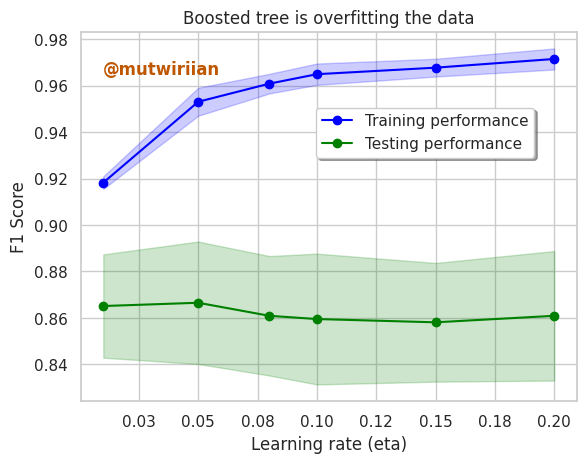

In [30]:
from matplotlib.ticker import StrMethodFormatter, FuncFormatter

ax = plt.subplot(1,1,1)

def format_y_ticks(value, _):
    return f"{value:.2f}"

plot_validation(train_scores_eta,test_scores_eta,param_range=param_range_eta,ax=ax)
plt.title('Boosted tree is overfitting the data')
plt.xlabel('Learning rate (eta)')
plt.ylabel('F1 Score')
plt.text(.01,.965,s = '@mutwiriian',fontweight='bold',color = '#BF5700')
#ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
#ax.xaxis.set_major_formatter(FuncFormatter(format_y_ticks))
ax.xaxis.set_major_formatter(formatter=StrMethodFormatter(fmt = '{x:.2f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter(fmt='{x:.2f}'))
plt.legend(bbox_to_anchor = (.93,.815),shadow=True, fancybox = True)
plt.savefig('../notebook/eta_validation.png',dpi = 300)

This is model does not provide much improvement to the tested classification models and so it is better off discarded.

In [31]:
models = ['Logistic Classifier: ','Support Vector Classifier: ','Random Forest Classifier: ']
accuracies = [logistic_accuracy,svc_model_accuracy,rdf_model_accuracy]
for model, acc in zip(models, accuracies):
    print(f'{model}: {np.round(acc,2)}')


Logistic Classifier: : 0.81
Support Vector Classifier: : 0.8
Random Forest Classifier: : 0.83


We can further combine the predictions of the individual models in order to obtain more robust prediction. This is known as stacking
This can be done by building a model that makes a final prediction based on the prediction of the classifiers specified.Here I choose the logistic regression model.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

estimators = [
    ('logistic',logistic_model),
    ('svc_model',svc_model),
    ('random_forest',rdf_model)
    ]

stacked_clf = StackingClassifier(
    estimators= estimators,
    final_estimator= LogisticRegression(),
    cv= 10
)

pred = stacked_clf.fit(X_train,y_train).score(X_test,y_test)
print(f'{pred:.2f}')

0.84


By averaging the predictions of the three models, we see much more accuracy and stable predictions
We can test the final model by passing a sample from the data

In [35]:
estimators = [
    ('logistic',logistic_model),
    ('svc_model',svc_model),
    ('random_forest',rdf_model)
    ]

sample = X_train.iloc[9,:]

preds = {}
#sample = np.array(sample).reshape(1,-1)
for name,model in estimators:
    ypred = model.predict(np.array(sample).reshape(1,-1))
    preds[name] = ypred


for name,y_pred in preds.items(): 
    print(f'Model {name}, Prediction {y_pred[0]}')

Model logistic, Prediction 1
Model svc_model, Prediction 0
Model random_forest, Prediction 1


In [36]:
sample

smv                  -1.050130
wip                  -0.144644
over_time            -1.220168
incentive            -0.857942
idle_time            -0.059684
idle_men             -0.115090
no_of_style_change   -0.375059
no_of_workers        -1.263400
quarter_quarter2      0.000000
quarter_quarter3      0.000000
quarter_quarter4      0.000000
quarter_quarter5      1.000000
department_sewing     0.000000
day_Saturday          0.000000
day_Sunday            0.000000
day_Thursday          1.000000
day_Tuesday           0.000000
day_Wednesday         0.000000
team_2                0.000000
team_3                0.000000
team_4                0.000000
team_5                0.000000
team_6                0.000000
team_7                0.000000
team_8                1.000000
team_9                0.000000
team_10               0.000000
team_11               0.000000
team_12               0.000000
Name: 9, dtype: float64

Here I save the sample data an array and dictionary for later when I will use it to test the deployed model

In [59]:
import json

sample_dict = dict(sample)
sample_arr = np.array(sample).reshape(1,-1)

formatted_array = '[' + ', '.join(map(str,sample_arr[0])) + ']'

with open('/home/mutwiri/DataScience/Python/garment_productivity_deployment/sample_array.txt','w') as f:
    f.write(formatted_array)
    
with open('/home/mutwiri/DataScience/Python/garment_productivity_deployment/sample_dict.txt', mode='w') as f:
    json.dump(sample_dict,f)

The models selects the class most frequently predicted(highest vote)

We can now go on save a our model object which can be integrated with other software to make predictions on new samples!

For deployment, I decided to take on a different approach. BentoML is model deployment framework which is optimzed for inference by reducing model latency. FastAPI would suffice but when it comes to scaling, BentoML wins. Once the model is saved in the Model Store, we can access it from anywhere and extend it into a service.

In [39]:
import bentoml

bentoml.sklearn.save_model('stacked_classifier',stacked_clf)

Model(tag="stacked_classifier:qfnbousri6hrkfmg", path="/home/mutwiri/bentoml/models/stacked_classifier/qfnbousri6hrkfmg/")

With everything successfully set up, we can the start the deployment process!